# Fitting dNdEta Distribution $n_{BC}$ Depandence $\Delta \eta$ 

## 熵密度分布的形式

### $$
% \begin{equation}
\begin{split}
e(\mathbf{x}_{\perp},\eta)
&=f_L(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \alpha}\\
&+f_R(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \alpha}\\
&+ F_{L,R}(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \beta}
\end{split}
% \end{equation}
$$

### $$F_{L,R}(\eta)=\left\{\begin{array}{ll}1,&\mathrm{if} |\eta|\leq\eta_\mathrm{flat}\\\exp\biggl(-\frac{(|\eta|-\eta_\mathrm{flat})^2}{2\eta_\mathrm{gw}^2}\biggr),&\mathrm{if} |\eta|>\eta_\mathrm{flat}\end{array}\right.$$

### $$f_{L,R}(\eta) = \exp\left(-\frac{(|\eta| \pm \eta_0)^2}{2 \sigma^2}\right)$$

### 这里 $f_L(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为左侧向右侧运动的d核的纵向分布函数；  
### $f_R(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为右侧向左侧运动的Au核的纵向分布函数

# 一、定义计算熵的类，对每个事件添加一个$n_{BC}^{i}$依赖的快度损失
### $$\Delta \eta_{i}=2 \frac{n_{BC}^{i}-n_{BC}^{min}}{n_{BC}^{max}-n_{BC}^{min}} + 1$$

In [1]:
import os
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.integrate import trapezoid, simpson
import matplotlib.pyplot as plt
import mplhep as hep
# Setting the plot style
hep.style.use('ATLAS')

from tqdm import tqdm
import h5py


In [2]:
class EntropyAndDSdEtaCalculator:
    """
    A class to calculate the dS/dEta distribution for different events.

    Parameters:
        eta (float): Maximum pseudorapidity value.
        slices (int): Number of slices in the pseudorapidity range.
        y_0 (float): Initial rapidity.
        sigma (float): Gaussian width.
        eta_flat (float): Flat region extent in the plateau function.
        eta_gw (float): Gaussian fall-off width in the plateau function.
        P_factor (float): Plateau scaling factor.
        L_factor (float): Left Gaussian scaling factor.
        R_factor (float): Right Gaussian scaling factor.
        alpha (float): Exponent for the left and right entropy.
        beta (float): Exponent for the plateau entropy.
    """

    def __init__(self, eta=6.9, slices=121, y_0=3.78, sigma=0.6, 
                 eta_flat=1.5, eta_gw=1.3, P_factor=1, L_factor=1, R_factor=1, alpha=2.0, beta=0.5):
        self.eta = eta
        self.slices = slices
        self.y_0 = y_0
        self.sigma = sigma
        self.L_factor = L_factor
        self.R_factor = R_factor
        self.P_factor = P_factor
        self.alpha = alpha
        self.beta = beta
        self.eta_flat = eta_flat
        self.eta_gw = eta_gw

    def gaussian_function(self, x=0, center=0, width=1):
        """Compute a Gaussian function."""
        return np.exp(-((x - center)**2) / (2 * width**2))

    def plateau_function(self, eta=np.linspace(-6.9, 6.9, 121)):
        """Compute the plateau function based on pseudorapidity."""
        heta = np.ones_like(eta)
        fall_off = np.abs(eta) > self.eta_flat
        eta_fall = np.abs(eta[fall_off])
        heta[fall_off] = np.exp(-(eta_fall - self.eta_flat)**2 / (2.0 * self.eta_gw**2))
        return heta

    def save_longitudinal_dis_coef(self, y_loss):
        """
        Compute the longitudinal distribution coefficients for left, right, and plateau.

        Parameters:
            y_loss (float): Rapidity loss.

        Returns:
            coef_l, coef_r, coef_lr: Arrays of coefficients.
        """
        etas = np.linspace(-self.eta, self.eta, self.slices)
        coef_l = self.L_factor * self.gaussian_function(x=etas, center=self.y_0-y_loss, width=self.sigma)
        coef_r = self.R_factor * self.gaussian_function(x=etas, center=-self.y_0, width=self.sigma)
        coef_p = self.P_factor * self.plateau_function(eta=etas)
        return coef_l, coef_r, coef_p

    def calc_dSdEta_part(self, entropy_200x200, coef_list):
        """
        Compute part of the dS/dEta distribution for a specific component.

        Parameters:
            entropy_200x200 (ndarray): 2D entropy data.
            coef_list (ndarray): Coefficient list.

        Returns:
            dSdEta_half: Part of the dS/dEta distribution.
        """
        dtau0 = 0.6
        dx = 0.1
        dy = 0.1
        deta = 0.115
        dtau = dtau0 * dx * dy * deta
        dSdEta_half = np.zeros(len(coef_list))
        for i, coef in enumerate(coef_list):
            dSdEta_half[i] = np.sum(entropy_200x200) * dtau * coef
        return dSdEta_half

    def calc_dSdEta(self, entropy_200x200_L, entropy_200x200_R, y_loss):
        """
        Calculate the total dS/dEta distribution.

        Parameters:
            entropy_200x200_L (ndarray): Left entropy data.
            entropy_200x200_R (ndarray): Right entropy data.
            y_loss (float): Rapidity loss.

        Returns:
            dSdEta: Total dS/dEta distribution.
        """
        self.coef_L, self.coef_R, self.coef_P = self.save_longitudinal_dis_coef(y_loss)
        entropy2d_plat = entropy_200x200_L * entropy_200x200_R
        dSdEta_L = self.calc_dSdEta_part(entropy_200x200_L**self.alpha, self.coef_L)
        dSdEta_R = self.calc_dSdEta_part(entropy_200x200_R**self.alpha, self.coef_R)
        dSdEta_P = self.calc_dSdEta_part(entropy2d_plat**self.beta, self.coef_P)
        dSdEta = dSdEta_L + dSdEta_R + dSdEta_P
        return dSdEta
    
    def calc_3D_entropy_part(self, entropy_2D, coef_list):
        """
        Calculate entropy 3D for a specific part
        Multiply a 2D matrix with a 1D coefficient list to produce a 3D matrix.
        """
        entropy_3D = np.zeros((len(coef_list), *entropy_2D.shape))
        for i, coef in enumerate(coef_list):
            entropy_3D[i] = entropy_2D * coef
        
        return entropy_3D

    def calc_entropy3D(self, entropy_200x200_L, entropy_200x200_R, y_loss):
        """
        Calculate the sum of three 3D entropy distribution.
        """
        self.coef_L, self.coef_R, self.coef_P = self.save_longitudinal_dis_coef(y_loss)
        entropy2d_combined = entropy_200x200_L * entropy_200x200_R
        entropy_L = self.calc_3D_entropy_part(entropy_200x200_L ** self.alpha, self.coef_L)
        entropy_R = self.calc_3D_entropy_part(entropy_200x200_R ** self.alpha, self.coef_R)
        entropy_P = self.calc_3D_entropy_part(entropy2d_combined ** self.beta, self.coef_P)
        return entropy_L + entropy_R + entropy_P


### 对每个事件添加一个$n_{BC}^{i}$依赖的快度损失
### $$\Delta \eta_{i}=\frac{n_{BC}^{i}-n_{BC}^{min}}{n_{BC}^{max}-n_{BC}^{min}} + 2$$

In [3]:
def calculate_event_dSdEta(event, input_dir, calculator, n_bc_min, n_bc_max):
    """
    Calculate dS/dEta for a specific event.

    Parameters:
        event (int): Event number.
        input_dir (str): Directory containing input files.
        calculator (dSdEtaCalculator): Calculator instance.
        n_bc_min (float): Minimum n_bc value.
        n_bc_max (float): Maximum n_bc value.

    Returns:
        dSdEta: Calculated dS/dEta distribution.
    """
    projectile_file = os.path.join(input_dir, f'entropy2d/projectile_entropy_event_{event}.dat')
    target_file = os.path.join(input_dir, f'entropy2d/target_entropy_event_{event}.dat')
    info_file = os.path.join(input_dir, f'information_of_d_Au_collision/event_{event}/information_of_output.dat')

    if os.path.exists(projectile_file) and os.path.exists(target_file) and os.path.exists(info_file):
        sum_gaussian_L = np.loadtxt(projectile_file)
        sum_gaussian_R = np.loadtxt(target_file)

        n_bc = np.loadtxt(info_file, usecols=5)
        y_loss = 1 * (n_bc - n_bc_min) / (n_bc_max - n_bc_min) + 2.0     ####  使用1+2的形式

        dSdEta = calculator.calc_dSdEta(sum_gaussian_L, sum_gaussian_R, y_loss)
        return dSdEta, y_loss
    else:
        print(f"Warning: Files for event {event} not found.")
        return None
    

def get_n_bc_range(input_dir, event_range):
    """
    Get the range of n_bc values from input files.

    Parameters:
        input_dir (str): Directory containing input files.
        event_range (list): Range of event numbers.

    Returns:
        n_bc_min, n_bc_max: Minimum and maximum n_bc values.
    """
    n_bc_values = []
    for event in range(event_range[0], event_range[1]):
        info_file = os.path.join(input_dir, f'information_of_d_Au_collision/event_{event}/information_of_output.dat')
        if os.path.exists(info_file):
            n_bc = np.loadtxt(info_file, usecols=5)
            n_bc_values.append(n_bc)
    return min(n_bc_values), max(n_bc_values)

def calculate_integral_dS(dsdeta,eta_range=[-2.2,2.2], method="trapezoid"):
    """
    Calculate the integral of the dS/dEta distribution.

    Parameters:
        dsdeta (ndarray): dS/dEta distribution.
        etas (ndarray): Pseudorapidity values.
        method (str): Integration method ("trapezoid" or "simpson").

    Returns:
        integral_dS: Integrated value of dS/dEta.
    """
    etas = np.linspace(-6.9, 6.9, 121)
    mask = (etas >=  eta_range[0]) & (etas <=  eta_range[1])
    if method == "trapezoid":
        integral_dS = trapezoid(dsdeta[mask], etas[mask]) 
    elif method == "simpson":
        integral_dS = simpson(dsdeta[mask], x=etas[mask]) 
    else:
        raise ValueError("Unsupported method: choose 'trapezoid' or 'simpson'")
    return integral_dS

# def calculate_integral_dS(dsdeta,eta_range=[-3.9,-3.1], method="trapezoid"):
#     """
#     Calculate the integral of the dS/dEta distribution.

#     Parameters:
#         dsdeta (ndarray): dS/dEta distribution.
#         etas (ndarray): Pseudorapidity values.
#         method (str): Integration method ("trapezoid" or "simpson").

#     Returns:
#         integral_dS: Integrated value of dS/dEta.
#     """
#     etas = np.linspace(-6.9, 6.9, 121)
#     mask = (etas >  eta_range[0]) & (etas <  eta_range[1])
#     if method == "trapezoid":
#         integral_dS = trapezoid(dsdeta[mask], etas[mask]) 
#     elif method == "simpson":
#         integral_dS = simpson(dsdeta[mask], x=etas[mask]) 
#     else:
#         raise ValueError("Unsupported method: choose 'trapezoid' or 'simpson'")
#     return integral_dS



In [4]:
def calc_dSdEta_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                    eta_flat=1.5, eta_gw=1.3, event_range=[0, 300],
                    L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                    HWF_or_DWF='HWF', num_workers=4):
    
    calculator = EntropyAndDSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                            y_0=y_0, sigma=sigma, alpha=alpha, beta=beta,
                                            L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)
    
    disk_2T = 'west16'
    input_dir = f'/media/mengzhu/{disk_2T}/d_Au_work2/d_Au_{HWF_or_DWF}/'
    n_bc_min, n_bc_max = get_n_bc_range(input_dir, event_range)
    
    dSdEta_event_all = []
    total_events = event_range[1] - event_range[0]
    
    # 修改后的进度条设置
    progress_bar = tqdm(
        total=total_events, 
        desc="处理事件", 
        unit="事件",
        mininterval=0.5,  # 降低刷新频率
        ncols=80,         # 固定宽度
        ascii=True        # 使用简单字符
    )

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {
            executor.submit(calculate_event_dSdEta, event, input_dir, calculator, n_bc_min, n_bc_max): event
            for event in range(event_range[0], event_range[1])
        }

        for future in as_completed(futures):
            event = futures[future]
            try:
                dSdEta_result, y_loss = future.result()
                if dSdEta_result is not None:
                    ds_total = calculate_integral_dS(dsdeta=dSdEta_result, method="trapezoid")
                    dSdEta_event_all.append([dSdEta_result, y_loss, event, ds_total])
            except Exception as e:
                print(f"\n事件 {event} 错误: {str(e)}")
            finally:
                progress_bar.update(1)
                # 减少postfix更新频率
#                 if progress_bar.n % 10 == 0:  
#                     progress_bar.set_postfix({'最新事件': event})

    progress_bar.close()
    
    if dSdEta_event_all:
        dSdEta_event_array = np.array(dSdEta_event_all, dtype=object)
        return dSdEta_event_array[np.argsort(dSdEta_event_array[:, 3])[::-1]]
    return np.array([])

In [5]:
def plot_dSdEta_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                    eta_flat=1.5, eta_gw=1.3, event_range=[0, 300],
                    L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                    HWF_or_DWF='HWF', num_workers=4, plot_dSdEta=True):
   
    # 计算该参数下ds_totall排序后的 dSdEta、y_loss、event、ds_totall 的结果
    dSdEta_event_array=calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                       eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                       L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                       alpha=alpha, beta=beta,
                                       HWF_or_DWF=HWF_or_DWF, num_workers=num_workers)
    
    if plot_dSdEta:
        plt.figure(figsize=(8, 6))
        eta_values = np.linspace(-eta, eta, slices)

        for dSdEta, y_loss, event, dS in dSdEta_event_array:
            plt.plot(eta_values, dSdEta, label=f'Event {event} (dS ={dS:.2f},dy={y_loss:.2f})', alpha=0.6)

        plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
        plt.ylabel(r'$\rm dS/d\eta$', fontsize=20, ha='center')
        plt.title(r'$\rm dS/d\eta$ Distribution'
                  + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
                  + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}', fontsize=20)
        plt.legend(fontsize=12, loc='upper right', ncol=1)
        plt.grid()

    return dSdEta_event_array


处理事件: 100%|#################################| 5/5 [00:00<00:00, 18.56事件/s]


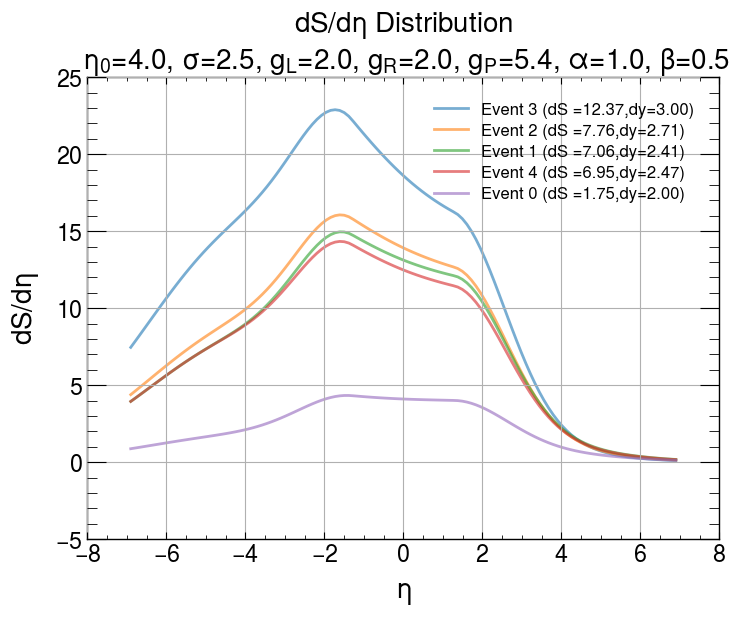

In [6]:
dSdEta_event_array =plot_dSdEta_ebe(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                    eta_flat=1.3, eta_gw=1.3, event_range=[0, 5],
                                    L_factor=2.0, R_factor=2.0, P_factor=5.4, alpha=1.0, beta=0.5,
                                    HWF_or_DWF='DWF', num_workers=4, plot_dSdEta=True)

In [7]:
dSdEta_event_array[:][:,-1]

array([12.370523986197894, 7.761639837396022, 7.063283805888371,
       6.951982529872379, 1.7479115041912745], dtype=object)

In [8]:
def subplot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                                  eta_flat=1.5, eta_gw=1.3, event_range=[0, 300],
                                  L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                                  percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                                  HWF_or_DWF='HWF', num_workers=4, plot_dSdEta=True,save_fig=False):
    """
    逐事件并行计算 dSdEta，并按积分值排序后，按百分比绘制不同中心度区间的 dSdEta 分布图。

    :param eta: 纵向快度范围
    :param slices: 快度切片个数
    :param y_0: 高斯分布中心参数
    :param sigma: 高斯分布宽度参数
    :param eta_flat: 平坦区域范围参数
    :param eta_gw: 平坦区域衰减宽度参数
    :param event_range: 要处理的事件范围
    :param L_factor, R_factor, P_factor: 理论模型参数
    :param alpha, beta: 指数参数
    :param percentiles: 百分比区间列表
    :param HWF_or_DWF: 数据类型 ('HWF' 或 'DWF')
    :param num_workers: 并行线程数量
    :param plot_dSdEta: 是否绘制图像

    :return: 按中心度排序的事件数据数组 (dSdEta, event_index, integral_value)
    """
    # 计算该参数下ds_totall排序后的 dSdEta、y_loss、event、ds_totall 的结果
    dSdEta_event_array=calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                       eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                       L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                       alpha=alpha, beta=beta,
                                       HWF_or_DWF=HWF_or_DWF, num_workers=num_workers)


    if plot_dSdEta:
        # 绘制不同中心度区间的图像
        eta_values = np.linspace(-eta, eta, slices)
        total_events = len(dSdEta_event_array)

        # 创建 2x3 的子图布局
        fig, axes = plt.subplots(2, 3, figsize=(16, 10))
        axes = axes.flatten()

        for idx, (start, end) in enumerate(percentiles):
            start_idx = int(total_events * start / 100)
            end_idx = int(total_events * end / 100)

            # 获取当前区间的所有事件的 dSdEta
            for i in range(start_idx, end_idx):
                dSdEta = dSdEta_event_array[i, 0]
                axes[idx].plot(eta_values, dSdEta, alpha=0.6)

            # 添加图例
            axes[idx].plot([], [], linestyle=' ', label=f'{start}-{end}')
            axes[idx].legend(loc='upper right', fontsize=20)
            axes[idx].set_xlabel(r'$\rm \eta$', fontsize=20,ha='center')
            axes[idx].set_ylabel(r'$\rm dS/d\eta}$', fontsize=20,ha='center')
            axes[idx].set_xlim(-eta, eta)
            axes[idx].grid(True, alpha=0.3)
            axes[idx].set_xlim(-8,8)  # 设置统一纵轴范围
            axes[idx].set_ylim(0,40)  # 设置统一纵轴范围
            axes[idx].grid(True,alpha=0.3)

        # 隐藏多余子图
        for ax in axes[len(percentiles):]:
            ax.axis('off')

#         plt.suptitle(r'Distribution of $\rm dS/d\eta$ by Centrality'
#                    + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
#                    + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}',fontsize=25)
        plt.suptitle(r'Distribution of $\rm dS/d\eta$ by Centrality',fontsize=25)
        plt.tight_layout()
        if save_fig:
            plt.savefig(f'fig/dSdeta_ebe_P_factor_{str(P_factor).replace(".", "p")}_beta_{str(beta).replace(".", "p")}_5000.pdf', bbox_inches='tight',dpi=100)
        plt.show()

#     return dSdEta_event_array


n_bc_min=1.0,n_bc_max=32.0


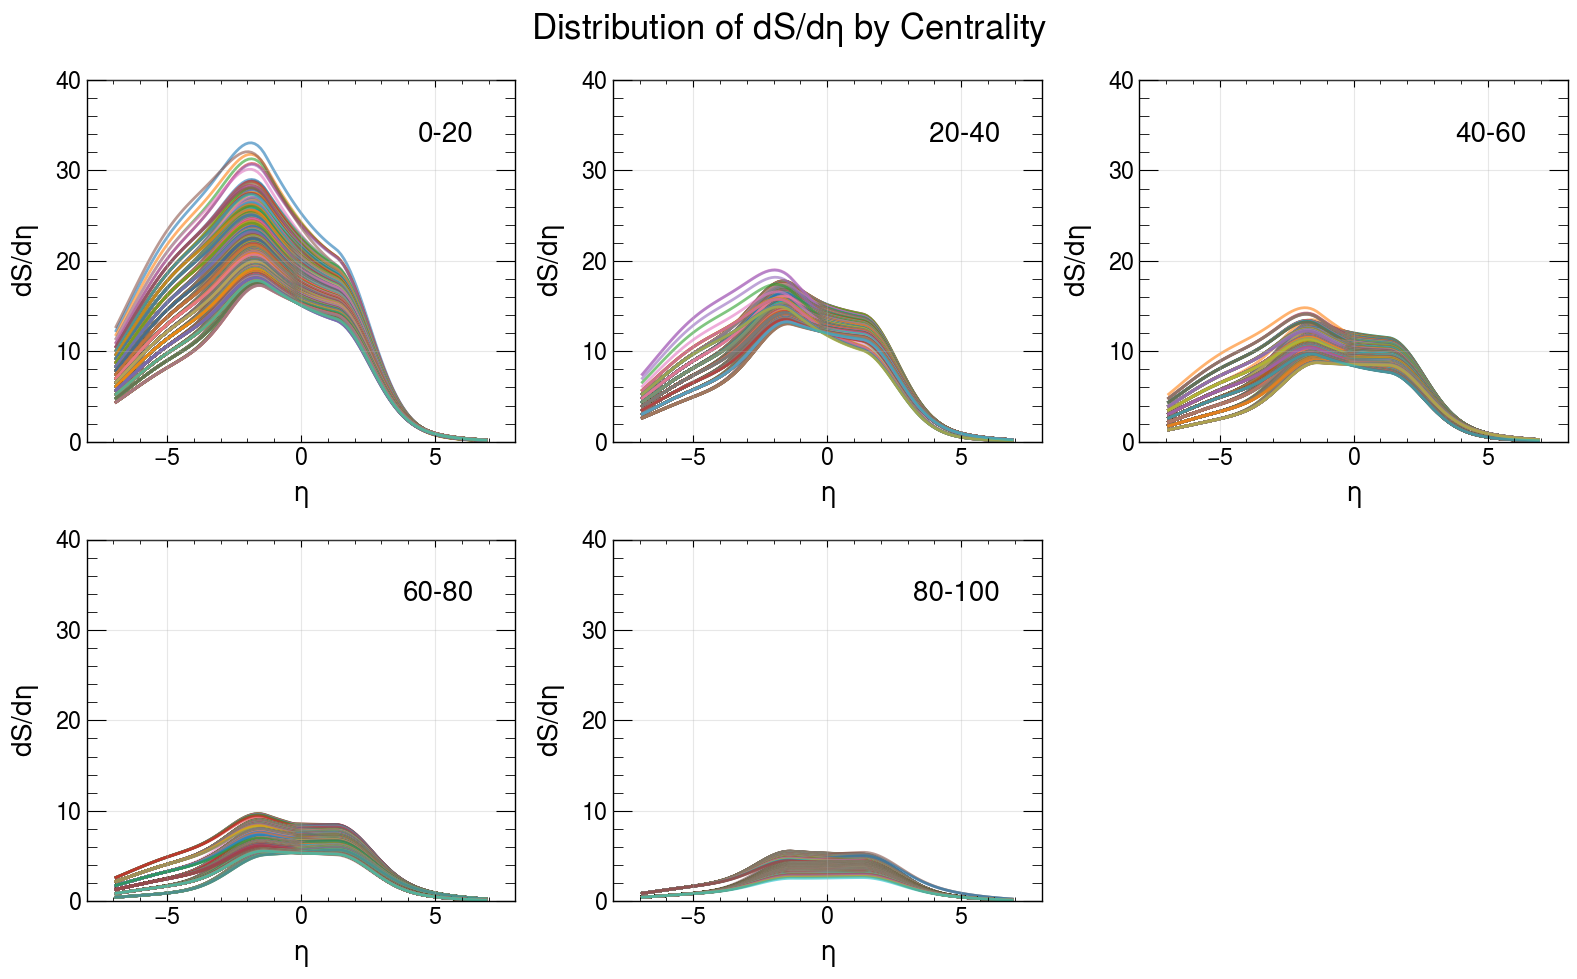

In [11]:
subplot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=4, sigma=2.5,
                              eta_flat=1.3, eta_gw=1.3, event_range=[0, 5000],
                              L_factor=2.0, R_factor=2.0, P_factor=5.4, alpha=1.0, beta=0.333,
                              percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                              HWF_or_DWF='DWF', num_workers=12, plot_dSdEta=True,save_fig=False)

In [9]:
def plot_avg_dSdEta_centrality(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                               eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300],
                               L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                               percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                               HWF_or_DWF='HWF', num_workers=4):
    """
    逐事件并行计算 dSdEta 和积分结果，将结果保存为数组，并计算每个中心度区间的平均 dSdEta。

    返回值包含每个事件的 dSdEta, 事件序号，以及积分值。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF
    :param num_workers: 并行线程数量
    :param percentiles: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    """
    # 计算该参数下ds_totall排序后的 dSdEta、y_loss、event、ds_totall 的结果

    dSdEta_event_array=calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                       eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                       L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                       alpha=alpha, beta=beta,
                                       HWF_or_DWF=HWF_or_DWF, num_workers=num_workers)

    # 绘制不同中心度区间的平均分布图像
    eta_values = np.linspace(-eta, eta, slices)
    total_events = len(dSdEta_event_array)

    average_distributions = []  # 用于保存每个中心度区间的平均分布

    for start, end in percentiles:
        start_idx = int(total_events * start / 100)
        end_idx = int(total_events * end / 100)

        # 获取当前区间的所有事件的 dSdEta
        dSdEta_subset = dSdEta_event_array[start_idx:end_idx, 0]

        # 计算平均分布
        avg_dSdEta = np.mean(np.vstack(dSdEta_subset), axis=0)
        average_distributions.append((avg_dSdEta, f'{start}-{end}%'))

    # 绘图
    plt.figure(figsize=(8, 6))
    colors = ['red', 'blue', 'green', 'orange', 'black']

    for idx, (avg_dist, label) in enumerate(average_distributions):
        plt.plot(eta_values, avg_dist, color=colors[idx % len(colors)], label=label, alpha=0.8)

    plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
    plt.ylabel(r'$\rm dS/d\eta}$', fontsize=20, ha='center')
    plt.title(r'Averaged $\rm dS/d\eta$ Distribution by Centrality'
              + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
              + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}', fontsize=25)
    plt.legend(fontsize=20, loc='upper right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



处理事件: 100%|#########################| 5000/5000 [00:03<00:00, 1259.02事件/s]


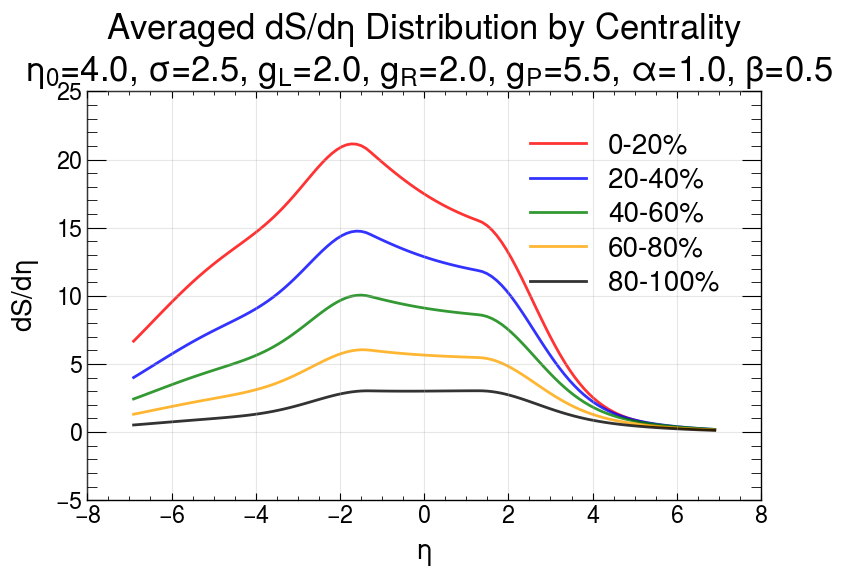

In [10]:
plot_avg_dSdEta_centrality(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                           eta_flat=1.3, eta_gw=1.3, event_range=[0, 5000],
                           L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                           percentiles = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                           HWF_or_DWF='DWF', num_workers=16)

# 计算用于流体的Entropy3D

In [9]:
def calc_event_indices_random(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                              eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300], IC_events=1000,
                              L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                              cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                              HWF_or_DWF='HWF', num_workers=4):
    """
    并行计算 dSdEta distribution 和相应 eta 区间的 dSdEta 对 eta 积分结果，
    并返回指定中心度区间内随机挑选的事件序号和 y_loss 值。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向 gaussian distribution 能量沉积的参数
    :param eta_flat, eta_gw: 参数影响 plateau 平坦区域和高斯宽度
    :param y_loss: 损失参数，d核核子碰撞后可能会有纵向停滞
    :param L_factor, R_factor, P_factor, alpha=1, beta=0.5: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF两种核结构
    :param num_workers: 并行线程数量
    :param cents: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    :return: 字典，包含每个中心度区间内的随机事件序号和对应的 y_loss 值。
    """
    dSdEta_event_array = calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                         eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                         L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                         alpha=alpha, beta=beta,
                                         HWF_or_DWF=HWF_or_DWF, num_workers=num_workers)

    # 提取每个中心度区间的事件序号和 y_loss 值
    total_events = len(dSdEta_event_array)
    centrality_results = {}

    for start, end in cents:
        print(f"Computing event numbers for centrality range {start}-{end}!")
        start_idx = int(total_events * start / 100)
        end_idx = int(total_events * end / 100)
        selected_data = dSdEta_event_array[start_idx:end_idx, 1:3]  # 提取 y_loss 和事件序号

        # 随机选择事件
        if len(selected_data) >= IC_events:
            random_samples = np.random.choice(len(selected_data), size=IC_events, replace=False)
            selected_samples = selected_data[random_samples]
        else:
            print(f"区间 {start}-{end} 的事件数量不足 {IC_events} 个！")
            selected_samples = selected_data

        # 保存随机挑选的事件信息
        centrality_results[f'{start}_{end}'] = {
            'y_loss': selected_samples[:, 0].tolist(),
            'event_indices': selected_samples[:, 1].astype(int).tolist()
        }

    return centrality_results


In [10]:
event_indices= calc_event_indices_random(
                    eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                    eta_flat=1.3, eta_gw=1.3, event_range=[0, 10],IC_events = 2,
                    L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.33,
                    cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                    HWF_or_DWF='DWF', num_workers=16
)

处理事件: 100%|###############################| 10/10 [00:00<00:00, 41.54事件/s]

Computing event numbers for centrality range 0-20!
Computing event numbers for centrality range 20-40!
Computing event numbers for centrality range 40-60!
Computing event numbers for centrality range 60-80!
Computing event numbers for centrality range 80-100!


In [11]:
event_indices

{'0_20': {'y_loss': [3.0, 2.8823529411764706], 'event_indices': [3, 9]},
 '20_40': {'y_loss': [2.6470588235294117, 2.7058823529411766],
  'event_indices': [8, 2]},
 '40_60': {'y_loss': [2.411764705882353, 2.4705882352941178],
  'event_indices': [1, 4]},
 '60_80': {'y_loss': [2.2941176470588234, 2.1176470588235294],
  'event_indices': [6, 7]},
 '80_100': {'y_loss': [2.0588235294117645, 2.0], 'event_indices': [5, 0]}}

In [12]:
for centrality, data in event_indices.items():
    print(centrality)
    print(data["y_loss"])
    print(data["event_indices"])    

0_20
[3.0, 2.8823529411764706]
[3, 9]
20_40
[2.6470588235294117, 2.7058823529411766]
[8, 2]
40_60
[2.411764705882353, 2.4705882352941178]
[1, 4]
60_80
[2.2941176470588234, 2.1176470588235294]
[6, 7]
80_100
[2.0588235294117645, 2.0]
[5, 0]


In [13]:
event_indices= calc_event_indices_random(
                    eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                    eta_flat=1.3, eta_gw=1.3, event_range=[0, 10],IC_events = 2,
                    L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.33,
                    cents=[(0, 30)],
                    HWF_or_DWF='DWF', num_workers=16
)

处理事件: 100%|##############################| 10/10 [00:00<00:00, 193.03事件/s]

Computing event numbers for centrality range 0-30!


In [14]:
event_indices

{'0_30': {'y_loss': [2.8823529411764706, 2.6470588235294117],
  'event_indices': [9, 8]}}

In [15]:
for centrality, data in event_indices.items():
    print(centrality)
    print(data["y_loss"])
    print(data["event_indices"])    

0_30
[2.8823529411764706, 2.6470588235294117]
[9, 8]


In [16]:
def calc_save_entropy3D_random(eta=6.9, slices=121, event_range=[0, 100], IC_events=10,
                               y_0=3.78, sigma=0.6, eta_flat=1.5, eta_gw=1.3,
                               P_factor=1, L_factor=1.0, R_factor=1.0, alpha=0.5, beta=2.0,  
                               cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)], 
                               HWF_or_DWF='HWF', save_entropy3d=False, num_workers=4):
    """
    保存不同中心度的 entropy3D 文件，从 event_0 开始编号。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param event_range: 事件范围1000*5
    :param y_0, sigma, eta_flat, eta_gw, P_factor, L_factor, R_factor, alpha, beta: 理论参数
    :param save_entropy3d: 是否保存文件
    :param HWF_or_DWF: 指定 HWF 或 DWF
    :param cents: 中心度划分
    :param num_workers: 并行线程数量
    """
    # 按中心度区间保存 entropy3D 文件
    if save_entropy3d:
        # 实例化计算器
        calculator = EntropyAndDSdEtaCalculator(eta=eta, slices=slices, 
                                                eta_flat=eta_flat, eta_gw=eta_gw, 
                                                y_0=y_0, sigma=sigma, 
                                                P_factor=P_factor, L_factor=L_factor, R_factor=R_factor, 
                                                alpha=alpha, beta=beta)

        # 计算中心度区间的事件序号
        print("centrality_event_indices is computing!")
        centrality_event_indices = calc_event_indices_random(
            eta=eta, slices=slices, y_0=y_0, sigma=sigma, 
            eta_flat=eta_flat, eta_gw=eta_gw,
            L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
            alpha=alpha, beta=beta, cents=cents, HWF_or_DWF=HWF_or_DWF, 
            num_workers=num_workers, event_range=event_range, IC_events=IC_events
        )
        print("centrality_event_indices has computed!")

        # 准备entropy3D输出路径参数
        base_output_dir = (f'/media/mengzhu/west16/d_Au_work2/d_Au_{HWF_or_DWF}/'
                           f'entropy3d/entropy3d_ebe_n_BC_check/plat_{str(eta_flat).replace(".", "p")}_gw_{str(eta_gw).replace(".", "p")}/')

        # 遍历中心度计算
        for centrality, centrality_data in tqdm(centrality_event_indices.items()):
            event_indices = centrality_data['event_indices']
            y_losses = centrality_data['y_loss']

            # 创建中心度子目录
            centrality_dir = os.path.join(base_output_dir, f'entropy_cent_{centrality}')
            os.makedirs(centrality_dir, exist_ok=True)

            # 构造输出文件名
            filename = (f"entropy3D_y0_{str(y_0).replace('.', 'p')}_sigma_{str(sigma).replace('.', 'p')}_"
                        f"L_factor_{str(L_factor).replace('.', 'p')}_R_factor_{str(R_factor).replace('.', 'p')}_"
                        f"P_factor_{str(P_factor).replace('.', 'p')}_alpha_{str(alpha).replace('.', 'p')}_"
                        f"beta_{str(beta).replace('.', 'p')}.h5")
            output_path = os.path.join(centrality_dir, filename)

            # 检查文件是否已经存在，避免覆盖
            if os.path.exists(output_path):
                print(f"File {output_path} already exists, skipping...")
                continue  # 跳过当前中心度的保存

            # 打印信息确认所计算的内容
            event_indices_len = len(event_indices)
            y_losses_len = len(y_losses)
            
            print(f"Centrality range {centrality} is computing! \n"
                  f"Included events with lens {event_indices_len}: \n {event_indices} \n"
                  f"Included y_loss with lens {y_losses_len}: \n {y_losses} \n")

            # 新建并打开 HDF5 文件
            with h5py.File(output_path, 'w') as f:  # 使用写模式 'w'
                for i, (event, y_loss) in tqdm(enumerate(zip(event_indices, y_losses))):
                    # entropy2d 输入路径
                    input_dir = (f'/media/mengzhu/west16/d_Au_work2/d_Au_{HWF_or_DWF}/entropy2d/')
                    input_filename_L = f"projectile_entropy_event_{event}.dat"
                    input_filename_R = f"target_entropy_event_{event}.dat"
                    input_path_L = os.path.join(input_dir, input_filename_L)
                    input_path_R = os.path.join(input_dir, input_filename_R)

                    # 读取输入文件
                    gaussian_L = np.loadtxt(input_path_L)
                    gaussian_R = np.loadtxt(input_path_R)

                    # 计算 entropy3D
                    entropy3D = calculator.calc_entropy3D(gaussian_L, gaussian_R, y_loss)

                    # 保存到文件，从 event_0 开始编号
                    dataset_name = f'event_{i}'  # 从 0 开始编号
                    f.create_dataset(dataset_name, data=entropy3D)
                    print(f"event_{event} renamed {dataset_name} added to {centrality_dir}.")
            print(f"entropy3D for {centrality} saved at {centrality_dir}\n")

    else:
        print("Please keep 'save_entropy3d=True'")


In [17]:
calc_save_entropy3D_random(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                           eta_flat=1.3, eta_gw=1.3,event_range=[0, 50000],IC_events=1000,
                           L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.35,
                           cents=[(0, 5)],
                           HWF_or_DWF='DWF', num_workers=16,save_entropy3d=True)

centrality_event_indices is computing!


处理事件: 100%|#########################| 50000/50000 [20:02<00:00, 41.60事件/s]


Computing event numbers for centrality range 0-5!
centrality_event_indices has computed!


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Centrality range 0_5 is computing! 
Included events with lens 1000: 
 [28962, 18229, 16664, 5404, 12994, 46166, 47351, 24310, 18769, 37544, 34808, 33324, 3271, 12701, 247, 25126, 12890, 22584, 417, 8968, 35133, 22096, 11367, 37133, 11795, 3133, 14656, 30601, 11472, 41083, 41252, 49524, 1278, 35420, 25187, 5185, 18856, 41371, 38725, 46937, 33724, 43408, 101, 37169, 30541, 32083, 30237, 27348, 26826, 5087, 35833, 4868, 25277, 27451, 42066, 16531, 13508, 47960, 38198, 24716, 11542, 786, 49006, 15165, 43142, 4932, 1455, 20361, 15871, 29332, 1910, 15172, 14677, 14133, 10994, 1695, 24078, 42280, 25526, 12407, 2804, 2714, 18988, 10857, 40893, 46752, 7046, 15441, 8778, 13771, 16425, 14684, 15733, 21140, 33472, 26929, 1763, 29042, 2391, 21821, 18331, 41000, 37534, 23836, 29909, 45511, 25531, 2303, 20332, 35875, 48739, 16983, 31092, 26007, 31052, 47237, 23851, 47111, 41676, 42079, 24606, 23800, 36124, 6404, 39302, 6260, 45348, 11607, 37110, 16108, 14158, 23780, 18412, 11530, 11727, 36168, 24508,


0it [00:00, ?it/s]

event_28962 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



2it [00:00, 10.00it/s]

event_18229 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



4it [00:00, 10.78it/s]

event_16664 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_5404 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_12994 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



6it [00:00, 12.18it/s]
8it [00:00, 12.94it/s]

event_46166 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47351 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24310 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



10it [00:00, 14.11it/s]
12it [00:00, 15.58it/s]

event_18769 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37544 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34808 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33324 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



14it [00:01, 14.44it/s]

event_3271 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_12701 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_247 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



16it [00:01, 13.97it/s]
18it [00:01, 13.18it/s]

event_25126 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_12890 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22584 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



20it [00:01, 12.87it/s]

event_417 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_8968 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35133 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



22it [00:01, 12.95it/s]
24it [00:01, 14.00it/s]

event_22096 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11367 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37133 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11795 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



26it [00:01, 13.44it/s]
28it [00:02, 14.14it/s]

event_3133 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14656 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_30601 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11472 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



30it [00:02, 14.70it/s]
32it [00:02, 15.51it/s]

event_41083 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41252 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49524 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



34it [00:02, 13.06it/s]

event_1278 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35420 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_25187 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



36it [00:02, 12.48it/s]
38it [00:02, 12.64it/s]

event_5185 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18856 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41371 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



40it [00:02, 14.13it/s]
42it [00:03, 14.51it/s]

event_38725 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46937 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33724 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43408 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



44it [00:03, 14.85it/s]
46it [00:03, 15.22it/s]

event_101 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37169 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_30541 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_32083 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



48it [00:03, 15.43it/s]

event_30237 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27348 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_26826 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



50it [00:03, 15.35it/s]
52it [00:03, 15.78it/s]

event_5087 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35833 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4868 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



54it [00:03, 14.51it/s]
56it [00:03, 15.02it/s]

event_25277 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27451 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42066 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16531 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



58it [00:04, 15.12it/s]
60it [00:04, 15.64it/s]

event_13508 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47960 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38198 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24716 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



62it [00:04, 15.11it/s]

event_11542 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_786 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49006 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



64it [00:04, 15.14it/s]
66it [00:04, 15.28it/s]

event_15165 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43142 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4932 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1455 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



68it [00:04, 14.23it/s]
70it [00:04, 13.31it/s]

event_20361 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15871 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_29332 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



72it [00:05, 10.57it/s]

event_1910 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15172 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14677 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



74it [00:05, 10.95it/s]
76it [00:05, 11.93it/s]

event_14133 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_10994 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1695 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



78it [00:05, 12.20it/s]
80it [00:05, 13.43it/s]

event_24078 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42280 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_25526 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_12407 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



82it [00:05, 13.93it/s]

event_2804 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_2714 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18988 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



84it [00:06, 13.11it/s]
86it [00:06, 13.28it/s]

event_10857 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_40893 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46752 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



88it [00:06, 12.89it/s]

event_7046 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15441 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_8778 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



90it [00:06, 13.56it/s]
92it [00:06, 14.30it/s]

event_13771 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16425 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14684 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



94it [00:06, 13.97it/s]
96it [00:06, 14.67it/s]

event_15733 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_21140 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33472 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_26929 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



98it [00:07, 14.13it/s]

event_1763 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_29042 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_2391 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



100it [00:07, 13.47it/s]
102it [00:07, 13.72it/s]

event_21821 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18331 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41000 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



104it [00:07, 14.22it/s]
106it [00:07, 14.78it/s]

event_37534 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23836 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_29909 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45511 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



108it [00:07, 14.68it/s]

event_25531 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_2303 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



110it [00:08, 12.78it/s]
112it [00:08, 13.89it/s]

event_20332 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35875 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48739 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16983 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



114it [00:08, 13.69it/s]
116it [00:08, 15.03it/s]

event_31092 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_26007 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_31052 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47237 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



118it [00:08, 15.16it/s]
120it [00:08, 16.23it/s]

event_23851 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47111 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41676 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42079 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



122it [00:08, 15.11it/s]

event_24606 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23800 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_36124 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



124it [00:08, 14.01it/s]
126it [00:09, 14.76it/s]

event_6404 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39302 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_6260 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45348 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



128it [00:09, 14.86it/s]
130it [00:09, 13.11it/s]

event_11607 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37110 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16108 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



132it [00:09, 14.00it/s]

event_14158 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23780 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18412 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



134it [00:10,  6.76it/s]
136it [00:10,  7.50it/s]

event_11530 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11727 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_36168 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24508 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



138it [00:12,  2.43it/s]
139it [00:12,  2.79it/s]

event_672 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_40062 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



140it [00:14,  1.35it/s]
142it [00:14,  2.05it/s]

event_5400 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33053 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49266 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49645 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



144it [00:16,  1.77it/s]

event_15695 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



145it [00:16,  1.89it/s]
147it [00:16,  2.79it/s]

event_9994 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_32339 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20388 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



148it [00:17,  2.25it/s]

event_17070 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



149it [00:18,  1.75it/s]

event_12310 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42305 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



151it [00:19,  1.64it/s]

event_3118 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48929 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



153it [00:20,  1.97it/s]
155it [00:20,  2.73it/s]

event_5225 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13908 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47344 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



156it [00:24,  1.01s/it]
158it [00:24,  1.48it/s]

event_768 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39840 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39552 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



159it [00:26,  1.16it/s]

event_23274 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



160it [00:27,  1.15it/s]

event_6443 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45553 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



162it [00:28,  1.40it/s]

event_26110 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



163it [00:28,  1.46it/s]

event_7399 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



164it [00:29,  1.39it/s]
166it [00:29,  2.22it/s]

event_29383 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20572 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_36208 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



167it [00:30,  1.51it/s]

event_14517 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



168it [00:32,  1.34it/s]

event_12452 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



169it [00:33,  1.22it/s]
171it [00:33,  2.01it/s]

event_3120 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_9587 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43440 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39106 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



173it [00:33,  2.94it/s]

event_33455 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



174it [00:34,  2.06it/s]
176it [00:34,  3.11it/s]

event_8459 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41518 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43915 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_28642 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



178it [00:36,  1.79it/s]

event_2893 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



179it [00:37,  1.58it/s]

event_9079 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39138 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



181it [00:38,  1.50it/s]
183it [00:38,  2.18it/s]

event_3783 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48140 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43837 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



184it [00:40,  1.48it/s]

event_20532 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



185it [00:41,  1.44it/s]

event_15495 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



186it [00:42,  1.37it/s]
188it [00:42,  2.15it/s]

event_12442 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_30949 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22951 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



189it [00:43,  1.79it/s]
190it [00:43,  2.24it/s]

event_29721 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22119 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37579 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



192it [00:43,  3.43it/s]
194it [00:43,  4.77it/s]

event_33467 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37580 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23882 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_31159 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



196it [00:43,  6.15it/s]
198it [00:43,  7.41it/s]

event_15854 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15236 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24246 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



200it [00:43,  8.86it/s]

event_39444 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_17335 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_6198 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



202it [00:44, 10.13it/s]
204it [00:44, 11.04it/s]

event_49069 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15964 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_3236 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



206it [00:44, 11.61it/s]

event_6133 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_9837 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11229 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



208it [00:44, 11.84it/s]
210it [00:44, 12.29it/s]

event_622 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16135 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33298 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



212it [00:44, 13.43it/s]
214it [00:44, 14.20it/s]

event_48525 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46852 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27467 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48240 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



216it [00:45, 14.50it/s]
218it [00:45, 14.64it/s]

event_27957 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34462 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_12035 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46429 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



220it [00:45, 14.20it/s]

event_22497 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20419 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11535 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



222it [00:45, 14.82it/s]
224it [00:45, 14.60it/s]

event_14741 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24943 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_949 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



226it [00:45, 15.06it/s]

event_32213 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49772 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46545 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



228it [00:45, 14.02it/s]
230it [00:46, 14.10it/s]

event_16966 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43427 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27488 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



232it [00:46, 13.89it/s]

event_19044 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7194 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33098 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



234it [00:46, 14.21it/s]
236it [00:46, 14.77it/s]

event_3513 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_19412 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42415 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



238it [00:46, 14.15it/s]

event_2308 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_12510 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7783 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



240it [00:46, 13.89it/s]
242it [00:46, 14.27it/s]

event_29442 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42895 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16962 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



244it [00:47, 13.44it/s]

event_11363 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14292 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23319 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



246it [00:47, 13.17it/s]
248it [00:47, 14.06it/s]

event_49087 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35423 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_21870 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7951 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



250it [00:47, 13.30it/s]
252it [00:47, 14.58it/s]

event_4326 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39342 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34086 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34578 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



254it [00:47, 14.74it/s]
256it [00:47, 14.73it/s]

event_26710 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14037 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22378 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



258it [00:48, 15.13it/s]

event_31550 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43220 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18595 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



260it [00:48, 14.15it/s]
262it [00:48, 14.78it/s]

event_20575 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_6433 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38539 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



264it [00:49,  5.37it/s]

event_10771 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44613 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_31185 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



266it [00:51,  2.23it/s]
268it [00:51,  3.01it/s]

event_6742 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_36275 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44000 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43361 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



270it [00:52,  2.43it/s]
272it [00:52,  3.27it/s]

event_10377 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34374 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49641 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_36230 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



274it [00:52,  4.35it/s]

event_44037 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



276it [00:54,  2.98it/s]

event_27082 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_21352 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38869 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



278it [00:54,  3.86it/s]

event_42173 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18247 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



280it [00:55,  2.32it/s]
282it [00:55,  3.13it/s]

event_24088 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45111 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38812 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48560 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



284it [00:56,  4.16it/s]

event_42393 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



286it [00:57,  2.84it/s]

event_15644 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45602 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



287it [00:58,  1.94it/s]

event_2847 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



288it [00:59,  1.77it/s]
290it [00:59,  2.62it/s]

event_4902 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_12281 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33846 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



291it [01:00,  1.70it/s]
293it [01:01,  2.52it/s]

event_17601 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49842 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24242 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



294it [01:01,  2.21it/s]
296it [01:01,  3.28it/s]

event_6505 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42951 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_21219 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34975 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



298it [01:01,  4.60it/s]

event_48423 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11209 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



300it [01:03,  2.31it/s]
302it [01:03,  3.22it/s]

event_31397 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_36673 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37166 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22676 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



304it [01:05,  1.83it/s]
305it [01:05,  2.13it/s]

event_26841 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24664 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11025 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



307it [01:06,  2.99it/s]

event_45865 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



308it [01:07,  2.22it/s]

event_16742 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



309it [01:08,  1.72it/s]

event_5224 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



310it [01:08,  1.62it/s]

event_16603 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24894 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



312it [01:09,  1.75it/s]
314it [01:09,  2.61it/s]

event_3977 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33639 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46608 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_17921 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



316it [01:10,  3.56it/s]

event_38890 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_32453 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



318it [01:12,  1.79it/s]

event_883 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33840 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



320it [01:12,  2.11it/s]
322it [01:13,  2.89it/s]

event_33607 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22319 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49395 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



323it [01:13,  3.32it/s]
325it [01:13,  4.52it/s]

event_24252 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4237 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_40572 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_10799 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



327it [01:13,  6.02it/s]
329it [01:13,  7.27it/s]

event_49383 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1835 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_30636 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



331it [01:13,  8.56it/s]

event_24848 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48245 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7165 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



333it [01:13,  9.21it/s]
335it [01:14, 10.37it/s]

event_28585 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37633 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35630 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41571 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



337it [01:14, 11.45it/s]
339it [01:14, 13.04it/s]

event_36218 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42368 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_30960 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48121 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



341it [01:14, 14.16it/s]
343it [01:14, 14.97it/s]

event_18741 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14116 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24507 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_30109 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



345it [01:14, 15.25it/s]
347it [01:14, 15.57it/s]

event_42041 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38956 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11345 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_31197 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



349it [01:14, 14.57it/s]
351it [01:15, 15.42it/s]

event_3059 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_9222 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47757 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35915 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



353it [01:15, 14.66it/s]

event_78 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34971 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



355it [01:16,  4.94it/s]

event_31879 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34384 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



357it [01:17,  2.81it/s]
359it [01:17,  3.72it/s]

event_10025 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44680 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44230 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_30761 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



361it [01:19,  2.19it/s]

event_23070 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



362it [01:20,  2.12it/s]

event_29337 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_36256 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



364it [01:23,  1.06it/s]

event_1216 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



365it [01:24,  1.17it/s]

event_21610 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



366it [01:26,  1.18s/it]
367it [01:26,  1.07it/s]

event_17729 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4375 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35998 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



369it [01:27,  1.70it/s]
370it [01:27,  2.08it/s]

event_26697 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33522 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_29377 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



372it [01:27,  3.06it/s]
373it [01:27,  3.49it/s]

event_24284 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_9 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



374it [01:27,  4.01it/s]
376it [01:27,  5.57it/s]

event_12521 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_5493 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4117 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



378it [01:27,  6.93it/s]

event_740 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24711 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7946 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



380it [01:28,  8.44it/s]
382it [01:28, 10.28it/s]

event_34282 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20084 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48422 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13829 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



384it [01:28, 10.88it/s]
386it [01:28, 10.72it/s]

event_647 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34650 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7114 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



388it [01:28, 12.13it/s]

event_39041 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49783 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14536 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



390it [01:28, 12.18it/s]
392it [01:28, 12.82it/s]

event_33245 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20715 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47676 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43400 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



394it [01:28, 14.07it/s]
396it [01:29, 14.24it/s]

event_9761 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_28322 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43956 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



398it [01:29, 14.06it/s]
400it [01:29, 15.28it/s]

event_13050 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20698 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41540 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_9902 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



402it [01:29, 15.62it/s]

event_19239 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_40279 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_26738 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



404it [01:29, 13.99it/s]
406it [01:29, 15.22it/s]

event_17968 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49511 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46875 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_10186 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



408it [01:29, 14.70it/s]
410it [01:30, 13.93it/s]

event_18056 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42554 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13371 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



412it [01:30, 13.79it/s]

event_26593 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_32955 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41961 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



414it [01:30, 14.15it/s]
416it [01:30, 14.26it/s]

event_14509 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_6273 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39727 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



418it [01:30, 12.73it/s]

event_24772 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_12300 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23681 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



420it [01:30, 12.98it/s]

event_32546 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18529 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



422it [01:31, 10.55it/s]
424it [01:31, 11.69it/s]

event_2481 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13903 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14026 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22606 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



426it [01:31, 12.48it/s]
428it [01:31, 12.84it/s]

event_46559 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_25171 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20443 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



430it [01:31, 13.73it/s]
432it [01:31, 14.24it/s]

event_49611 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_19623 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_19807 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37826 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



434it [01:31, 14.60it/s]
436it [01:32, 15.10it/s]

event_47655 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_28048 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_9805 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_40117 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



438it [01:32, 14.98it/s]

event_40832 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33054 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23150 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



440it [01:32, 14.61it/s]
442it [01:32, 13.72it/s]

event_7335 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1762 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_9710 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



444it [01:32, 14.40it/s]
446it [01:32, 14.84it/s]

event_20036 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38094 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39490 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15223 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



448it [01:32, 14.55it/s]

event_35526 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_21976 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_8958 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



450it [01:33, 14.10it/s]
452it [01:33, 14.54it/s]

event_31495 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_8238 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_21257 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



454it [01:33, 14.15it/s]

event_13379 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_31712 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_40490 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



456it [01:33, 14.48it/s]
458it [01:33, 15.27it/s]

event_33937 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48326 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38925 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_3481 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



460it [01:33, 14.22it/s]
462it [01:33, 14.39it/s]

event_11855 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34054 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41435 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



464it [01:34, 13.43it/s]
466it [01:34, 14.10it/s]

event_9835 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35175 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_19320 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_32410 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



468it [01:34, 14.20it/s]

event_39724 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_8521 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16732 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



470it [01:34, 14.20it/s]
472it [01:34, 14.45it/s]

event_42320 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13919 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_29671 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



474it [01:34, 14.38it/s]
476it [01:34, 14.87it/s]

event_11319 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_31441 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43423 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47336 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



478it [01:35, 13.34it/s]

event_1727 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11898 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4218 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



480it [01:35, 14.19it/s]
482it [01:35, 15.34it/s]

event_39005 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38530 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43852 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_25504 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



484it [01:35, 14.75it/s]
486it [01:35, 13.36it/s]

event_31814 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27624 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4055 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



488it [01:35, 12.83it/s]

event_35561 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18705 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_5261 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



490it [01:35, 13.23it/s]
492it [01:36, 14.06it/s]

event_30052 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18959 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47431 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27976 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



494it [01:36, 14.01it/s]

event_22621 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



496it [01:36,  6.73it/s]

event_21744 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15846 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23148 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



498it [01:37,  4.84it/s]

event_36483 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_26399 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



500it [01:38,  3.86it/s]

event_33234 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



501it [01:38,  3.02it/s]

event_1900 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_19669 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



503it [01:42,  1.28it/s]

event_1949 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



504it [01:42,  1.39it/s]

event_11567 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



505it [01:44,  1.18it/s]
507it [01:44,  1.84it/s]

event_4751 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_19961 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43139 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



508it [01:45,  1.29it/s]

event_1729 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



509it [01:46,  1.16it/s]
511it [01:47,  1.86it/s]

event_7954 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46794 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39618 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



512it [01:48,  1.51it/s]

event_7206 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44136 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



514it [01:48,  1.99it/s]

event_19027 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43602 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



516it [01:50,  1.70it/s]

event_28673 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



517it [01:50,  1.61it/s]

event_16084 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



518it [01:52,  1.34it/s]
520it [01:52,  2.11it/s]

event_35818 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44943 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42077 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



521it [01:53,  1.73it/s]

event_2251 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



522it [01:53,  1.77it/s]

event_3 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



523it [01:54,  1.84it/s]

event_7304 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



524it [01:55,  1.39it/s]

event_6828 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18633 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



526it [01:56,  1.45it/s]

event_34144 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13167 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



528it [01:57,  1.48it/s]
530it [01:58,  2.16it/s]

event_36219 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46882 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_40771 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



532it [01:58,  3.07it/s]

event_34923 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38278 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



533it [01:59,  1.79it/s]

event_27362 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



534it [02:00,  1.72it/s]

event_18185 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41779 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



536it [02:01,  1.69it/s]

event_20078 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



537it [02:02,  1.54it/s]

event_9577 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



538it [02:02,  1.60it/s]
540it [02:03,  2.52it/s]

event_22331 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39996 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42447 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



541it [02:04,  1.78it/s]

event_36177 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44039 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



543it [02:05,  1.55it/s]

event_1826 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46354 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



545it [02:06,  1.67it/s]

event_8351 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



546it [02:07,  1.41it/s]

event_132 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



547it [02:09,  1.21it/s]

event_4100 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



548it [02:10,  1.08it/s]

event_30343 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



549it [02:10,  1.25it/s]

event_13685 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



550it [02:12,  1.06it/s]
551it [02:12,  1.38it/s]

event_14563 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_5838 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



553it [02:12,  2.27it/s]

event_47568 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11525 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_25391 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



555it [02:12,  3.28it/s]
557it [02:12,  4.32it/s]

event_13478 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27690 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37296 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



559it [02:13,  5.67it/s]

event_48039 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16083 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39308 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



561it [02:13,  6.90it/s]
563it [02:13,  8.30it/s]

event_13276 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4914 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37866 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



565it [02:13,  8.81it/s]

event_7839 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1137 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



567it [02:14,  3.43it/s]

event_5718 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49277 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



568it [02:15,  2.48it/s]

event_24934 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



569it [02:17,  1.73it/s]
571it [02:17,  2.60it/s]

event_30772 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42663 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49868 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15237 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



573it [02:17,  3.52it/s]
575it [02:17,  4.82it/s]

event_46355 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46593 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34527 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_28686 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



577it [02:17,  6.16it/s]
579it [02:17,  7.54it/s]

event_31801 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_10904 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39137 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



581it [02:17,  8.70it/s]

event_18144 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44141 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_9113 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



583it [02:18,  9.88it/s]
585it [02:18, 10.54it/s]

event_19863 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_2776 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_28843 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



587it [02:18, 11.05it/s]

event_21518 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_32021 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42790 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



589it [02:18, 11.07it/s]
591it [02:18, 12.21it/s]

event_9421 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23206 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_8758 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_8562 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



593it [02:18, 12.88it/s]
595it [02:18, 13.17it/s]

event_10417 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27078 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22917 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



597it [02:20,  4.39it/s]

event_8405 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7060 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_40095 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



599it [02:20,  3.42it/s]

event_11594 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



600it [02:21,  2.72it/s]
602it [02:21,  3.70it/s]

event_36366 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22642 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38802 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



603it [02:22,  3.09it/s]

event_23905 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20415 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



605it [02:24,  1.82it/s]
607it [02:24,  2.59it/s]

event_1576 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47592 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46376 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



608it [02:25,  1.96it/s]

event_18524 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44773 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



610it [02:26,  1.96it/s]

event_10700 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



611it [02:26,  2.09it/s]
613it [02:26,  3.09it/s]

event_15797 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46828 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47766 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



614it [02:27,  3.57it/s]
616it [02:27,  5.00it/s]

event_25991 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20973 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_31132 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



618it [02:27,  6.24it/s]

event_6359 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34718 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23180 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



620it [02:27,  7.62it/s]
622it [02:27,  9.42it/s]

event_43857 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_32490 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44114 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13153 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



624it [02:27, 10.32it/s]
626it [02:27, 10.35it/s]

event_33669 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_9777 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37958 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



628it [02:28, 11.45it/s]

event_42342 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_19277 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38898 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



630it [02:28, 11.56it/s]
632it [02:28, 11.78it/s]

event_30512 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_26116 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47329 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



634it [02:28, 12.73it/s]

event_30586 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47965 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39390 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



636it [02:28, 13.07it/s]
638it [02:28, 13.23it/s]

event_25300 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27445 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_19994 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



640it [02:28, 13.52it/s]

event_9704 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11623 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24849 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



642it [02:29, 13.45it/s]
644it [02:29, 13.54it/s]

event_32650 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_5536 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_6695 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



646it [02:29, 14.06it/s]
648it [02:29, 14.35it/s]

event_4651 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11825 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15103 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1395 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



650it [02:29, 13.81it/s]
652it [02:29, 14.35it/s]

event_2429 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46630 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15041 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34376 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



654it [02:29, 14.15it/s]

event_25663 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34946 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_40477 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



656it [02:30, 13.94it/s]
658it [02:30, 14.50it/s]

event_38412 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34219 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34575 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33516 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



660it [02:30, 14.53it/s]
662it [02:30, 13.82it/s]

event_22634 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4718 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_19824 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



664it [02:30, 14.42it/s]
666it [02:30, 15.04it/s]

event_5792 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37116 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24004 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35887 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



668it [02:30, 15.45it/s]

event_43807 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_19661 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_8336 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



670it [02:31, 15.20it/s]
672it [02:31, 14.42it/s]

event_13653 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16982 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20468 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



674it [02:31, 15.14it/s]
676it [02:31, 14.86it/s]

event_41209 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_42324 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11481 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38598 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



678it [02:31, 14.60it/s]
680it [02:31, 15.23it/s]

event_19434 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23598 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_28077 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35341 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



682it [02:31, 14.63it/s]

event_24231 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_615 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13849 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



684it [02:32, 14.10it/s]
686it [02:32, 14.39it/s]

event_3471 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_12650 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15492 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



688it [02:32, 12.78it/s]

event_3857 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_10427 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_9433 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



690it [02:32, 13.09it/s]
692it [02:32, 14.19it/s]

event_29998 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35356 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_6043 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_17398 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



694it [02:32, 14.13it/s]
696it [02:32, 14.39it/s]

event_36334 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23020 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37883 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24051 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



698it [02:33, 15.11it/s]
700it [02:33, 15.67it/s]

event_46173 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16509 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_28092 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35372 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



702it [02:33, 15.27it/s]
704it [02:33, 15.64it/s]

event_16745 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43213 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_32843 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24749 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



706it [02:33, 15.84it/s]
708it [02:33, 15.74it/s]

event_12743 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33359 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14042 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



710it [02:33, 15.59it/s]
712it [02:33, 16.32it/s]

event_14979 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45341 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43077 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45484 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



714it [02:34, 15.03it/s]
716it [02:34, 16.00it/s]

event_28630 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_2815 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_29400 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_21181 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



718it [02:34, 15.95it/s]

event_19406 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46483 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_858 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



720it [02:34, 14.73it/s]
722it [02:34, 15.82it/s]

event_32606 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_36460 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45919 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22847 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



724it [02:34, 16.07it/s]
726it [02:34, 16.93it/s]

event_24821 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49685 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43470 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_28109 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



728it [02:34, 15.75it/s]
730it [02:35, 15.93it/s]

event_41079 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1399 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45232 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22434 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



732it [02:35, 15.34it/s]
734it [02:35, 15.77it/s]

event_11893 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7943 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_31121 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11348 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



736it [02:35, 15.33it/s]
738it [02:35, 15.04it/s]

event_34914 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18693 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38232 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45335 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



740it [02:36,  7.46it/s]

event_41266 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18312 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



742it [02:36,  5.04it/s]
744it [02:36,  6.32it/s]

event_8058 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_10804 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45333 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33156 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



746it [02:38,  3.73it/s]

event_8625 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44433 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



748it [02:38,  3.02it/s]

event_32940 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



749it [02:39,  3.20it/s]

event_41108 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



750it [02:39,  2.93it/s]

event_34665 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



751it [02:41,  1.62it/s]

event_30414 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



752it [02:42,  1.30it/s]

event_10120 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



753it [02:43,  1.14it/s]

event_3531 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45346 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



755it [02:45,  1.07it/s]

event_519 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



756it [02:46,  1.16it/s]

event_22238 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



757it [02:46,  1.25it/s]

event_7074 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



758it [02:47,  1.16it/s]

event_14274 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



759it [02:48,  1.18it/s]

event_31199 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



760it [02:49,  1.07it/s]

event_4628 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



761it [02:50,  1.20it/s]

event_22658 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



762it [02:52,  1.13s/it]

event_38537 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



763it [02:53,  1.18s/it]

event_5151 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



764it [02:55,  1.32s/it]

event_8848 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49438 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



766it [02:56,  1.04s/it]

event_39739 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



767it [02:58,  1.19s/it]

event_33160 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



768it [02:58,  1.04s/it]

event_41711 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



769it [03:01,  1.47s/it]

event_3578 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49361 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



771it [03:03,  1.20s/it]

event_19697 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



772it [03:04,  1.07s/it]

event_2790 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38525 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



774it [03:05,  1.17it/s]

event_12340 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



775it [03:05,  1.24it/s]

event_31926 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44958 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



777it [03:06,  1.51it/s]

event_38228 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



778it [03:07,  1.43it/s]
780it [03:07,  2.18it/s]

event_13876 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16312 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44462 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



782it [03:07,  3.07it/s]

event_35795 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_6092 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24097 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



784it [03:07,  4.10it/s]
786it [03:08,  5.17it/s]

event_22754 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_29517 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_17618 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



788it [03:08,  6.37it/s]
790it [03:08,  7.77it/s]

event_3696 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46033 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41282 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48147 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



792it [03:08,  9.10it/s]

event_25951 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23866 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48788 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



794it [03:08, 10.24it/s]
796it [03:08, 10.67it/s]

event_18919 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39398 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18603 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



798it [03:08, 11.97it/s]
800it [03:09, 12.59it/s]

event_6985 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23697 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_8134 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11192 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



802it [03:09, 13.03it/s]

event_21155 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1573 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_32100 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



804it [03:09, 13.45it/s]
806it [03:09, 13.64it/s]

event_48307 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_6896 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41274 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



808it [03:09, 14.04it/s]
810it [03:09, 15.28it/s]

event_34791 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_30554 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44116 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18975 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



812it [03:09, 14.21it/s]

event_36457 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_36556 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47752 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



814it [03:10, 14.70it/s]
816it [03:10, 14.23it/s]

event_24082 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_40408 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_31570 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



818it [03:10, 13.83it/s]

event_23674 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41535 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13158 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



820it [03:10, 13.59it/s]
822it [03:10, 13.76it/s]

event_30150 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35769 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20273 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



824it [03:10, 13.59it/s]

event_5684 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7673 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_10549 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



826it [03:10, 12.89it/s]
828it [03:11, 13.26it/s]

event_43323 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_5379 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13358 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11343 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



830it [03:11, 14.33it/s]
832it [03:11, 14.97it/s]

event_13588 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_45702 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34094 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



834it [03:11, 14.96it/s]
836it [03:11, 14.98it/s]

event_35819 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46267 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_17402 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4870 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



838it [03:11, 15.98it/s]
840it [03:11, 15.52it/s]

event_45342 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44884 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_29195 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34130 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



842it [03:11, 14.76it/s]
844it [03:12, 15.26it/s]

event_14794 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13286 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27404 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_28135 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



846it [03:12, 15.90it/s]
848it [03:12, 15.58it/s]

event_24204 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11701 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_15666 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_8508 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



850it [03:12, 14.08it/s]
852it [03:12, 14.67it/s]

event_1200 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_2252 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14626 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49164 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



854it [03:12, 15.21it/s]
856it [03:12, 15.31it/s]

event_47017 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_16052 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49531 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_19921 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



858it [03:13, 14.13it/s]

event_19741 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14696 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23153 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



860it [03:13, 13.84it/s]
862it [03:13, 13.65it/s]

event_29823 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7346 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24764 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



864it [03:13, 13.74it/s]

event_44841 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27873 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41784 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



866it [03:13, 13.78it/s]
868it [03:13, 13.67it/s]

event_34871 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4552 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7966 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



870it [03:13, 14.42it/s]
872it [03:14, 14.92it/s]

event_25315 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37097 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49070 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43103 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



874it [03:14, 14.34it/s]
876it [03:14, 14.83it/s]

event_4707 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4411 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_17457 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_21323 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



878it [03:14, 14.20it/s]

event_34807 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_31559 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18911 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



880it [03:14, 14.43it/s]
882it [03:14, 14.95it/s]

event_9362 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4563 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23267 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38623 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



884it [03:14, 14.75it/s]
886it [03:14, 15.08it/s]

event_19259 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_3961 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43343 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35669 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



888it [03:15, 15.27it/s]
890it [03:15, 16.25it/s]

event_41448 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47459 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46425 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1447 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



892it [03:15, 15.42it/s]
894it [03:15, 14.79it/s]

event_18525 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47233 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22622 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



896it [03:15, 15.27it/s]

event_46084 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_3011 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43078 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



898it [03:15, 14.93it/s]
900it [03:15, 13.40it/s]

event_4860 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1968 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_21449 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



902it [03:16, 12.99it/s]

event_38876 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_3495 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7729 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



904it [03:16, 14.03it/s]

event_47838 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23978 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



906it [03:16,  6.72it/s]
908it [03:17,  7.95it/s]

event_40093 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33730 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41255 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



910it [03:17,  5.74it/s]

event_6165 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1893 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_8082 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



912it [03:18,  4.26it/s]

event_28529 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



913it [03:20,  1.80it/s]

event_13937 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



914it [03:21,  1.56it/s]

event_21758 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47320 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



916it [03:22,  1.73it/s]

event_8087 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



917it [03:22,  1.78it/s]

event_24914 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



918it [03:25,  1.03it/s]

event_15338 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



919it [03:26,  1.18s/it]

event_2622 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



920it [03:28,  1.16s/it]

event_5054 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



921it [03:29,  1.13s/it]

event_35744 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



922it [03:30,  1.08s/it]

event_18119 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



923it [03:31,  1.09s/it]

event_28461 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



924it [03:31,  1.05it/s]

event_12203 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



925it [03:33,  1.05s/it]

event_21247 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



926it [03:34,  1.22s/it]
928it [03:34,  1.45it/s]

event_1580 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48758 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_7262 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



929it [03:35,  1.26it/s]

event_12323 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



930it [03:36,  1.40it/s]
932it [03:36,  2.26it/s]

event_10121 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48866 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27692 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



933it [03:38,  1.34it/s]

event_41038 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



934it [03:38,  1.46it/s]

event_10104 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



935it [03:40,  1.12it/s]

event_10172 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



936it [03:41,  1.08it/s]

event_34581 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



937it [03:42,  1.12it/s]

event_4161 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_49206 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



939it [03:44,  1.11s/it]

event_45556 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



940it [03:46,  1.22s/it]
941it [03:46,  1.06it/s]

event_7164 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11092 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22889 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



943it [03:46,  1.67it/s]
944it [03:47,  2.05it/s]

event_2271 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_25322 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_27897 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



946it [03:47,  3.13it/s]
948it [03:47,  4.30it/s]

event_22660 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_32135 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_10503 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



950it [03:47,  5.57it/s]

event_33916 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_11734 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4304 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



952it [03:47,  7.00it/s]
954it [03:47,  8.59it/s]

event_44400 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34168 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_26858 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_36761 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



956it [03:47,  9.67it/s]
958it [03:48, 10.17it/s]

event_40592 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22057 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39297 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



960it [03:48, 11.49it/s]
962it [03:48, 12.17it/s]

event_37254 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_47227 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24478 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23580 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



964it [03:48, 13.30it/s]
966it [03:48, 13.51it/s]

event_22247 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_29529 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_2515 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_44955 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



968it [03:48, 13.70it/s]
970it [03:48, 14.29it/s]

event_25068 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_20156 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_31405 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_14553 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



972it [03:48, 14.94it/s]

event_11392 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_46462 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_38513 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



974it [03:49, 14.70it/s]
976it [03:49, 13.91it/s]

event_36417 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_13430 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_10014 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



978it [03:49, 13.64it/s]
980it [03:49, 14.44it/s]

event_41614 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_43509 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_22348 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_23033 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



982it [03:49, 14.59it/s]
984it [03:49, 14.67it/s]

event_18905 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_4442 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_18950 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_17298 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



986it [03:49, 13.86it/s]

event_23342 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_34987 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_1971 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



988it [03:50, 13.36it/s]
990it [03:50, 13.70it/s]

event_13570 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_35811 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_41256 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



992it [03:50, 14.36it/s]
994it [03:50, 14.88it/s]

event_34532 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_24203 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_39131 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_5112 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.



996it [03:50, 14.63it/s]


event_19221 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_33407 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_48231 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_37511 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.


998it [03:50, 14.79it/s]
1000it [03:50,  4.33it/s]
100%|████████████████████████████████████████████| 1/1 [03:50<00:00, 230.94s/it]

event_34760 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
event_763 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5.
entropy3D for 0_5 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_5

